In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from imblearn.over_sampling import SMOTE

In [2]:
train_df = pd.read_csv('fraudTrain.csv')
test_df = pd.read_csv('fraudTest.csv')


In [3]:
df = pd.concat([train_df, test_df], axis=0)


In [4]:
def preprocess_data(df):
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day'] = df['trans_date_trans_time'].dt.day
    df['month'] = df['trans_date_trans_time'].dt.month
    df['dayofweek'] = df['trans_date_trans_time'].dt.dayofweek
    
    categorical_cols = ['category', 'gender']
    df = pd.get_dummies(df, columns=categorical_cols)
    
    cols_to_drop = ['trans_date_trans_time', 'merchant', 'first', 'last', 'street', 'city', 'state', 'job', 'dob', 'trans_num', 'unix_time']
    df = df.drop(columns=cols_to_drop)
    
    return df

df_processed = preprocess_data(df)


In [5]:
X = df_processed.drop('is_fraud', axis=1)
y = df_processed['is_fraud']


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


C:\Users\harsh\anaconda3\envs\deepfake_detector\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\harsh\anaconda3\envs\deepfake_detector\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\harsh\anaconda3\envs\deepfake_detector\lib\subprocess.py", line 493, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\harsh\anaconda3\envs\deepfake_detector\lib\subprocess.py", line 858, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\harsh\anaconda3\envs\deepfake_detector\lib\subprocess.py", line 1327, in _execute_

In [9]:
X_train_reshaped = X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)


In [10]:
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


In [11]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [14]:
history = model.fit(
    X_train_reshaped, y_train_resampled, 
    epochs=10, 
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
73710/73710 [==============================] - 201s 3ms/step - loss: 0.1353 - accuracy: 0.9456 - val_loss: 0.1472 - val_accuracy: 0.9446
Epoch 2/10
73710/73710 [==============================] - 202s 3ms/step - loss: 0.0877 - accuracy: 0.9661 - val_loss: 0.0779 - val_accuracy: 0.9727
Epoch 3/10
73710/73710 [==============================] - 202s 3ms/step - loss: 0.0695 - accuracy: 0.9738 - val_loss: 0.0653 - val_accuracy: 0.9782
Epoch 4/10
73710/73710 [==============================] - 196s 3ms/step - loss: 0.0594 - accuracy: 0.9782 - val_loss: 0.0715 - val_accuracy: 0.9786
Epoch 5/10
73710/73710 [==============================] - 195s 3ms/step - loss: 0.0528 - accuracy: 0.9812 - val_loss: 0.0451 - val_accuracy: 0.9896
Epoch 6/10
73710/73710 [==============================] - 195s 3ms/step - loss: 0.0485 - accuracy: 0.9831 - val_loss: 0.0400 - val_accuracy: 0.9908
Epoch 7/10
73710/73710 [==============================] - 196s 3ms/step - loss: 0.0451 - accuracy: 0.9845 - val_

In [15]:
from sklearn.metrics import accuracy_score

y_train_pred = (model.predict(X_train_reshaped) > 0.5).astype(int)
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)

# Calculate testing accuracy
y_test_pred = (model.predict(X_test_reshaped) > 0.5).astype(int)
test_accuracy = accuracy_score(y_test, y_test_pred)

y_pred_proba = model.predict(X_test_reshaped)
y_pred = (y_pred_proba > 0.5).astype(int)


print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"\nAUC-ROC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Average Precision Score: {average_precision_score(y_test, y_pred_proba):.4f}")

11578/11578 [==============================] - 13s 1ms/step
Training Accuracy: 0.9913
Testing Accuracy: 0.9847
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    368549
           1       0.24      0.91      0.38      1930

    accuracy                           0.98    370479
   macro avg       0.62      0.95      0.69    370479
weighted avg       1.00      0.98      0.99    370479


Confusion Matrix:
[[363047   5502]
 [   173   1757]]

AUC-ROC Score: 0.9912
Average Precision Score: 0.8051


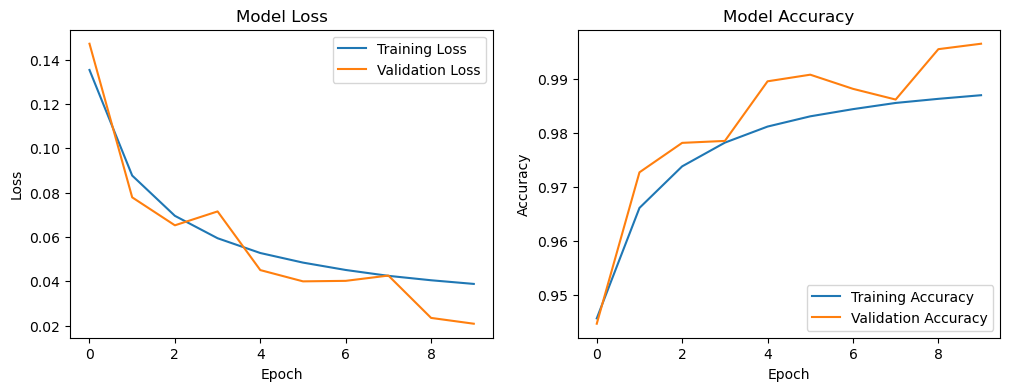

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

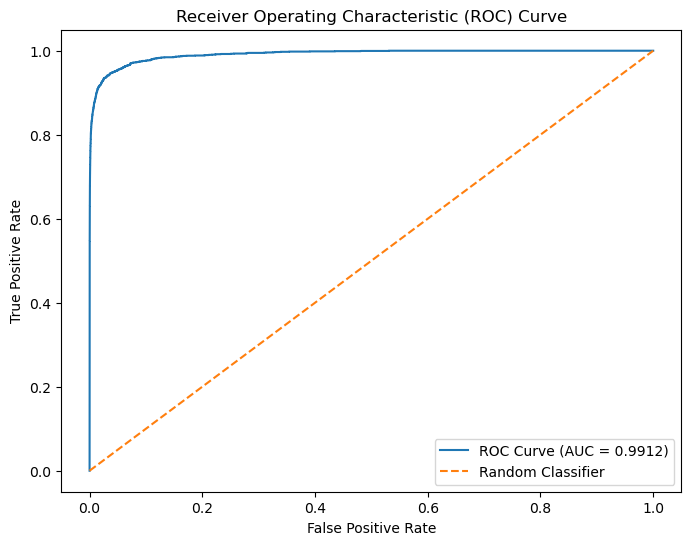

In [17]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

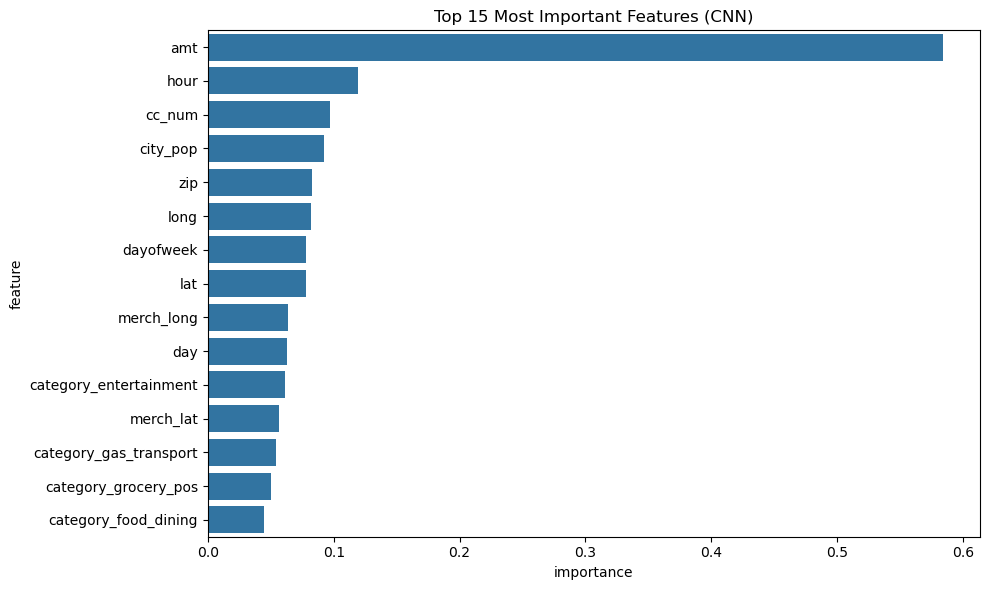

Top 15 Most Important Features:
               feature  importance
                   amt    0.584466
                  hour    0.119668
                cc_num    0.096905
              city_pop    0.091955
                   zip    0.083043
                  long    0.081553
             dayofweek    0.078155
                   lat    0.077703
            merch_long    0.063701
                   day    0.062872
category_entertainment    0.061104
             merch_lat    0.056803
category_gas_transport    0.053966
  category_grocery_pos    0.050123
  category_food_dining    0.044259


In [24]:
def get_gradients(model, inputs, target):
    inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
    target = tf.convert_to_tensor(target, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        predictions = model(inputs)
        loss = tf.keras.losses.binary_crossentropy(target, predictions)
    return tape.gradient(loss, inputs)

sample_size = min(1000, X_test_reshaped.shape[0])
sample_indices = np.random.choice(X_test_reshaped.shape[0], sample_size, replace=False)
sample_X = X_test_reshaped[sample_indices]
sample_y = y_test.iloc[sample_indices].values.reshape(-1, 1)  # Reshape to 2D array

gradients = get_gradients(model, sample_X, sample_y)
feature_importance = np.mean(np.abs(gradients.numpy()), axis=0).squeeze()

# Create a DataFrame of feature importances
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15))
plt.title('Top 15 Most Important Features (CNN)')
plt.tight_layout()
plt.show()

print("Top 15 Most Important Features:")
print(feature_importance_df.head(15).to_string(index=False))